---
# WISDM

**W**ireless **S**ensor **D**ata **M**ining: 스마트폰 가속도 센서 값

---

## Subject : 시계열데이터(time_series_data)를 CNN Model에 입력하기 위한 가공 과정

---
### 1) Data 설명

**Columns** : user_id, activity, timestamp, x, y, z

- `user_id`: 고유번호
- `activity`: label, 어떤 활동을 하고 있었는지
- `timestamp`: 1차원, 시간 흐름
- `x, y, z`: features, (x, y, z)축


### 2) 왜 시계열을 2D로 바꾸는가?

- CNN은 2D 처리를 더 잘하기 때문에 `Conv1D`를 사용하기 위해서,
- ‘윈도우’로 잘라서 2D Matrix 형태로 바꿔주는 것.
    
    → CNN: 시간축 X 채널축 = 2D 를 학습하게 만듦
    
    → (기존 CNN: 행 X 열 = 2D 학습)
    

### 3) Window slicing을 하면…

frame_size = 128 → shape = (128, 3) = (length, channels)

### 4) CNN에 들어가려면…

- *PyTorch* 기준으로 `Conv1D = (batch, channels, length)`로 입력을 받는다.
    
    (`Conv2D = (N, C, H, W) = (개 채 행 열)`)
    
- 그렇기에 우선 (128, 3)을 (3, 128)로 Transpose 해야함.
- 그다음, 최종 shape = (N, 3, 128)

In [1]:
from google.colab import drive

# 구글 드라이브 마운트
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

- WISDM 데이터 파일 구조\
33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;\
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;\
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;

In [3]:
def load_data(path):
  '''
  데이터 불러올 함수
    - path만 지정해주면 필요한 전처리 진행
    - 전처리 요소
      - CSV 파일의 ','를 기준으로 나누기
      - 세미콜론 제거
      - 숫자형으로 변환
      - 결측치 제거
  '''
  df = pd.read_csv(
      path,
      header=None,
      delimiter=",",
      engine="python",
      on_bad_lines="skip",
      na_values=["nan","NaN","NAN","null","None","", "nan;","NaN;","NAN;","null;","None;"],  # <- 문자열 'nan' 등도 NaN으로 인식
      keep_default_na=True,
  )
  df = df.iloc[:, :6].copy()
  df.columns = ["user_id","label","timestamp","x","y","z"]

  # 공백/세미콜론/문자 'nan' 정리 후 숫자화
  for c in ["x","y","z"]:
      s = df[c].astype(str).str.strip().str.replace(";", "", regex=False)
      # 남아 있는 'nan/null/none' 같은 문자열을 NaN으로 통일
      s = s.mask(s.str.lower().isin(["nan","null","none",""]))
      df[c] = pd.to_numeric(s, errors="coerce")

  # 숫자/라벨 빠진 행 제거
  df = df.dropna(subset=["x","y","z","label"]).reset_index(drop=True)
  return df

In [4]:
def make_windows(df, frame_size=128, hop_size=64):
  '''
  Sliding Window 구현 함수
    - frame_size & hop_size는 각각 고정
    - (시간축 X 채널축)으로 변환
    - X, y로 나누기 -> np.array로 변환한 값 반환
  '''
  X, y = [], []
  values = df[["x", "y", "z"]].values.astype(np.float32)
  labels = df["label"].values

  for i in range(0, len(df) - frame_size, hop_size):
    X.append(values[i:i+frame_size])
    win_label = pd.Series(df['label'][i:i+frame_size]).mode()[0]  # 해당 구간에서 가장 많은 라벨 선택
    y.append(win_label)

  return np.array(X), np.array(y)

#### 정규화 과정
1. `train set`의 각 축(x,y,z)에 대한 mean과 std 구하기
2. 각 데이터에서 mean을 빼고 std로 나누기
3. 모든 축의 데이터 분포가 mean=0, std=1로 맞춰진다.
- `test set`은 학습이 끝나고 따로 정규화를 해서 분포를 맞춰준채로 Test한다.


In [5]:
def split_and_norm(X, y, val_size=0.2, test_size=0.2):
  '''
  학습, 테스트셋으로 나누고 정규화 하는 함수
  '''
  X_train, X_temp, y_train, y_temp = train_test_split(
      X, y, test_size=(val_size+test_size), random_state=42, stratify=y
  )

  relative_test_size = test_size / (val_size + test_size)
  X_val, X_test, y_val, y_test = train_test_split(
      X_temp, y_temp, test_size=relative_test_size, random_state=42, stratify=y_temp
  )

  # 정규화
  mean = X_train.mean(axis=(0,1), keepdims=True)
  std = X_train.std(axis=(0,1), keepdims=True) + 1e-8

  X_train = (X_train - mean) / std
  X_val = (X_val - mean) / std
  X_test = (X_test - mean) / std

  return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
class TimeseriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    # (L, C) -> Transpose (C, L) => .transpose(0, 1)
    xi = torch.from_numpy(self.X[i]).transpose(0, 1).contiguous().float()
    yi = torch.tensor(self.y[i], dtype=torch.long)  # long: 정수 인덱싱
    return xi, yi

In [7]:
class SimpleCNN1D(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.simplenet = nn.Sequential(
        nn.Conv1d(3, 64, 5, padding=2), nn.ReLU(),
        nn.MaxPool1d(2),
        nn.Conv1d(64, 128, 5, padding=2), nn.ReLU(),
        nn.MaxPool1d(2),
        nn.AdaptiveAvgPool1d(1),
        nn.Flatten(),
        nn.Linear(128, n_classes)
    )

  def forward(self, x):
    return self.simplenet(x)

In [13]:
def train(model, train_loader, val_loader, test_loader, epochs=20, lr=1e-3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)

    history = {"train_loss": [], "train_acc": [], "val_acc": []}

    for ep in range(1, epochs+1):
        # ----- Training -----
        model.train()
        total, correct, loss_sum = 0, 0, 0.0

        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True).float()
            yb = yb.to(device, non_blocking=True).long()

            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total += yb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
            loss_sum += loss.item() * yb.size(0)

        train_loss = loss_sum / total
        train_acc  = correct / total

        # ----- Validation -----
        model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device, non_blocking=True).float()
                yb = yb.to(device, non_blocking=True).long()
                logits = model(xb)
                total += yb.size(0)
                correct += (logits.argmax(1) == yb).sum().item()
        val_acc = correct / total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {ep}: train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

    # ----- 최종 Test -----
    total, correct = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device, non_blocking=True).float()
            yb = yb.to(device, non_blocking=True).long()
            logits = model(xb)
            total += yb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
    test_acc = correct / total
    print(f"Final Test Accuracy = {test_acc:.3f}")

    return history, test_acc


In [14]:
if __name__ == "__main__":
    PATH = "/content/drive/MyDrive/Colab Notebooks/data/WISDM_ar_v1.1_raw.txt"

    df = load_data(PATH)
    X, y = make_windows(df, frame_size=128, hop_size=64)
    X_train, X_val, X_test, y_train, y_val, y_test = split_and_norm(X, y)

    # 라벨 인코딩
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val   = le.transform(y_val)
    y_test  = le.transform(y_test)
    n_classes = len(le.classes_)

    # Dataset 생성
    train_ds = TimeseriesDataset(X_train, y_train)
    val_ds   = TimeseriesDataset(X_val, y_val)
    test_ds  = TimeseriesDataset(X_test, y_test)

    # DataLoader 생성
    train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=1024, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=1024, shuffle=False)

    # 모델 & 학습
    model = SimpleCNN1D(n_classes)
    history, test_acc = train(
      model,
      train_loader=train_loader,
      val_loader=val_loader,
      test_loader=test_loader,
      epochs=20,
      lr=1e-3
    )

Epoch 1: train_loss=1.2808, train_acc=0.516, val_acc=0.687
Epoch 2: train_loss=0.9321, train_acc=0.698, val_acc=0.718
Epoch 3: train_loss=0.7484, train_acc=0.730, val_acc=0.739
Epoch 4: train_loss=0.6424, train_acc=0.748, val_acc=0.753
Epoch 5: train_loss=0.5654, train_acc=0.787, val_acc=0.803
Epoch 6: train_loss=0.5013, train_acc=0.817, val_acc=0.822
Epoch 7: train_loss=0.4533, train_acc=0.832, val_acc=0.831
Epoch 8: train_loss=0.4132, train_acc=0.844, val_acc=0.844
Epoch 9: train_loss=0.3873, train_acc=0.855, val_acc=0.872
Epoch 10: train_loss=0.3606, train_acc=0.868, val_acc=0.859
Epoch 11: train_loss=0.3406, train_acc=0.876, val_acc=0.870
Epoch 12: train_loss=0.3210, train_acc=0.883, val_acc=0.882
Epoch 13: train_loss=0.3030, train_acc=0.891, val_acc=0.888
Epoch 14: train_loss=0.2869, train_acc=0.902, val_acc=0.899
Epoch 15: train_loss=0.2729, train_acc=0.907, val_acc=0.900
Epoch 16: train_loss=0.2596, train_acc=0.913, val_acc=0.911
Epoch 17: train_loss=0.2474, train_acc=0.917, val

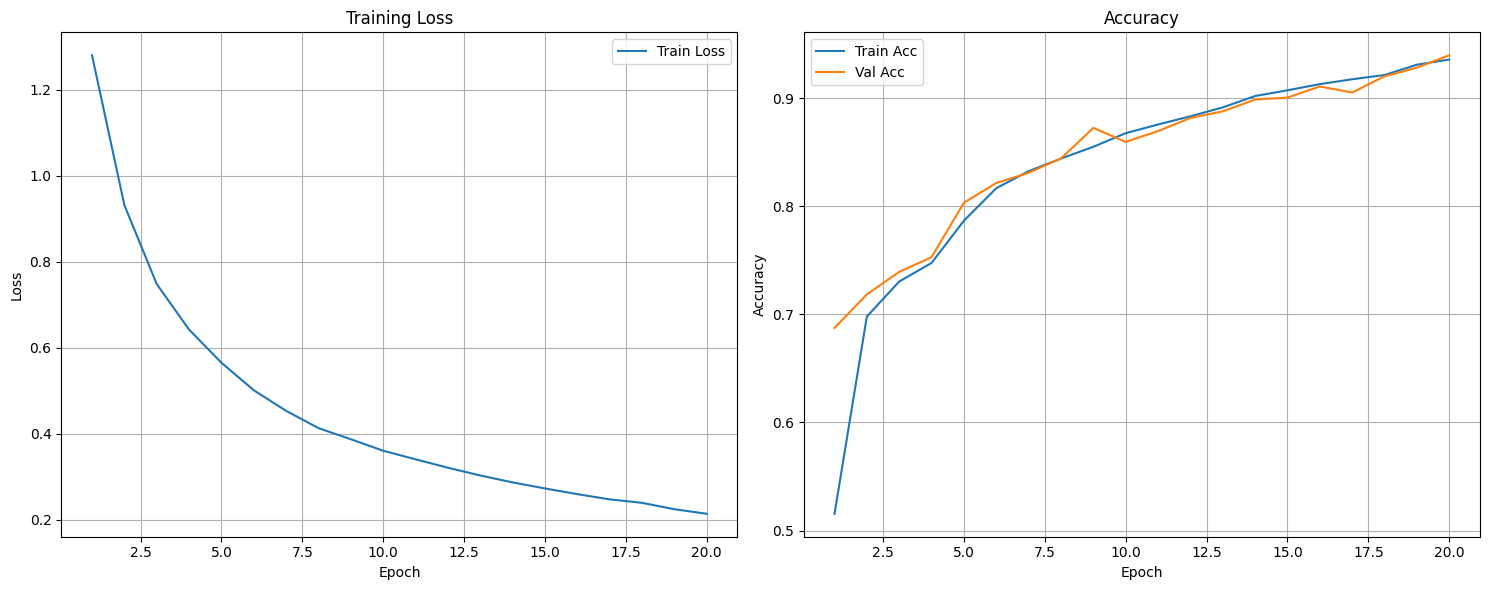

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(15,6))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    if "val_acc" in history:
        plt.plot(epochs, history["val_acc"], label="Val Acc")
    if "test_acc" in history:
        plt.plot(epochs, history["test_acc"], label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 실행
plot_history(history)